In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed Aug 10 13:17:46 2022

@author: BetzLab-Admin
"""

import sys
sys.path.append('../../lib')
from time import sleep
from pipython import GCSDevice
from pipython import pitools
from scipy.signal import fftconvolve
import keyboard
from math import cos, sin, pi
import numpy as np
from pycromanager import Core,Studio
from detection_methods import trajectory_corr, trajectory_gauss, trajectory_mean,trajectory_till, trajectory_till_stepwise,most_common_value, compare_trajectories, plt_accuracy_results, trajectory_polar_comparison,save_result, load_result, trajectory_polar_comparison
from detection_methods import make_test_trajectory as make_movie
import matplotlib.pyplot as plt
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage import label
from microscope_functions import snap_image, move_large_stage, calibration_matrix, center_crop, fullscreen, move_stage, beat_to_center, center_object, optimal_z_position
import csv
import random
import os
import json
#from pipython.datarectools import getservotime

#core.set_exposure(0.5)##sets the cameras exposure time for snapshots to half a milisecond

C:\Users\jschulz\AppData\Local\Temp\ipykernel_3084\2487153334.py:21: DeprecationWarning: Please use `maximum_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import maximum_filter


In [2]:
pidevice= GCSDevice('E-727')
STAGES=None
REFMODES=None
core=Core()
pidevice.InterfaceSetupDlg()

pidevice.SVO('1', True)
pidevice.SVO('2', True)
pidevice.SVO('3', True)
core.set_exposure(100)

In [3]:

def make_test_trajectory(min_step,max_step,timesteps):
    # Generate random angles between 0 and 2*pi
    angles = np.random.uniform(low=0, high=2*np.pi, size=(timesteps, 1))

    # Generate random norms between 0 and 1
    if max_step==0:
        norms=np.zeros((timesteps, 1))
    else:
        norms = np.random.uniform(low=np.log(min_step), high=np.log(max_step), size=(timesteps, 1))
        norms=np.exp(norms)

    # Create an Nx2 numpy array with each row having a random norm between 0 and 1
    space_steps = np.hstack((norms * np.cos(angles), norms * np.sin(angles)))

    place=[0,0]
    trajectory=[place]
    for step in space_steps:
        place=place+step
        trajectory.append(place)
    return np.array(trajectory),np.array(space_steps)

    


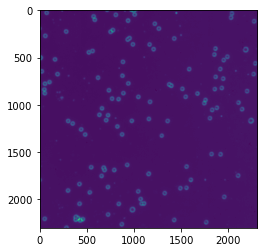

In [4]:
fullscreen()
img_0=snap_image()
plt.imshow(img_0)


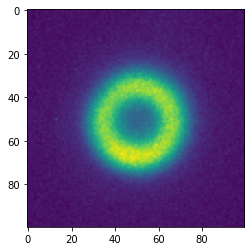

In [5]:
beat_to_center()
center_crop()
img_1=snap_image()
plt.imshow(img_1)

In [6]:
calibration_file = 'C:\\Users\\BetzLab-Admin\\Desktop\\git-code\\mbr_relevant_code\\callibrations\\small_stage\\small_stage_fixed_calibration_images\\fit_parameters.json'
matrix=calibration_matrix(calibration_file)
pixel_to_motor=np.linalg.inv(matrix)


In [7]:
experiment_folder='Y:\\Julian\\fixed_beat_experiments\\location_validation_experiments'
experiment_name='calibration_2'

In [8]:
if not os.path.exists(experiment_folder+'\\'+experiment_name):
    os.mkdir(experiment_folder+'\\'+experiment_name)

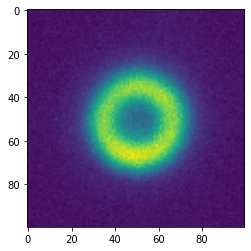

In [9]:
center_object()
optimal_z_position()
img_1=snap_image()
plt.imshow(img_1)

In [10]:
for exposure in [25,50,100,200,400]:
    core.set_exposure(exposure)
    experiment_name='exposure_'+str(exposure)
    if not os.path.exists(experiment_folder+'\\'+experiment_name):
        os.mkdir(experiment_folder+'\\'+experiment_name)
    for i in range(10):
        np.save(experiment_folder+'\\'+experiment_name+'\\'+'exposion.npy',np.array([core.get_exposure()]))
        datapoint_name='datapoint_'+str(i)

        core.set_exposure(100)
        center_object()
        for j in range(2):
            optimal_z_position()
        core.set_exposure(exposure)

        points,steps=make_test_trajectory(.01,1,100)
        start_position=np.array([50,50])
        motor_positions=[start_position-pixel_to_motor.dot(point) for point in points]

        img_list=[] 
        for position in motor_positions:
            move_stage(pidevice, 1, position[0])
            move_stage(pidevice, 2, position[1])
            sleep(0.1)
            img_list.append(snap_image())

        movie=np.array(img_list)
        os.mkdir(experiment_folder+'\\'+experiment_name+'\\'+datapoint_name)

        np.save(experiment_folder+'\\'+experiment_name+'\\'+datapoint_name+'\\'+'movie.npy',movie)
        np.save(experiment_folder+'\\'+experiment_name+'\\'+datapoint_name+'\\'+'points.npy',points)
        np.save(experiment_folder+'\\'+experiment_name+'\\'+datapoint_name+'\\'+'steps.npy',steps)

KeyboardInterrupt: 

In [3]:
import numpy as np
import os

# Assuming that the trajectory functions are defined:
# trajectory_corr(), trajectory_gauss(), trajectory_mean(), trajectory_till(), trajectory_till_stepwise()

def compute_trajectories_for_datapoint(datapoint_folder):
    # Load the movie
    movie = np.load(os.path.join(datapoint_folder, 'movie.npy'))
    
    # Compute the trajectories
    tra_corr = trajectory_corr(movie)
    tra_gauss = trajectory_gauss(movie)
    tra_mean = trajectory_mean(movie)
    tra_till = trajectory_till(movie)
    tra_till_stepwise = trajectory_till_stepwise(movie)
    
    # Save the trajectories
    np.save(os.path.join(datapoint_folder, 'tra_corr.npy'), tra_corr)
    np.save(os.path.join(datapoint_folder, 'tra_gauss.npy'), tra_gauss)
    np.save(os.path.join(datapoint_folder, 'tra_mean.npy'), tra_mean)
    np.save(os.path.join(datapoint_folder, 'tra_till.npy'), tra_till)
    np.save(os.path.join(datapoint_folder, 'tra_till_stepwise.npy'), tra_till_stepwise)


# Loop over all data points and compute trajectories
for i in range(50):
    datapoint_name = 'datapoint_' + str(i)
    datapoint_folder = os.path.join(experiment_folder, experiment_name, datapoint_name)
    
    compute_trajectories_for_datapoint(datapoint_folder)


c:\Users\BetzLab-Admin\Desktop\git-code\mbr_relevant_code\experiments\method_comparison\../../lib\detection_methods.py:200: RuntimeWarning: invalid value encountered in sqrt
  return popt, np.sqrt(np.diag(pcov))
c:\Users\BetzLab-Admin\anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Error during fitting: Optimal parameters not found: Number of calls to function has reached maxfev = 1200.
Error during fitting: Optimal parameters not found: Number of calls to function has reached maxfev = 1200.
Error during fitting: Optimal parameters not found: Number of calls to function has reached maxfev = 1200.
Error during fitting: Optimal parameters not found: Number of calls to function has reached maxfev = 1200.
Error during fitting: Optimal parameters not found: Number of calls to function has reached maxfev = 1200.
Error during fitting: Optimal parameters not found: Number of calls to function has reached maxfev = 1200.
Error during fitting: Optimal parameters not found: Number of calls to function has reached maxfev = 1200.


In [91]:

# Create empty lists to store concatenated trajectories and points
all_tra_corr = []
all_tra_gauss = []
all_tra_mean = []
all_tra_till = []
all_tra_till_stepwise = []
all_points = []

# Function to load and append trajectories and points for a given datapoint
def load_and_append_trajectories_and_points(datapoint_folder):
    all_tra_corr.append(np.load(os.path.join(datapoint_folder, 'tra_corr.npy')))
    all_tra_gauss.append(np.load(os.path.join(datapoint_folder, 'tra_gauss.npy')))
    all_tra_mean.append(np.load(os.path.join(datapoint_folder, 'tra_mean.npy')))
    all_tra_till.append(np.load(os.path.join(datapoint_folder, 'tra_till.npy')))
    all_tra_till_stepwise.append(np.load(os.path.join(datapoint_folder, 'tra_till_stepwise.npy')))
    all_points.append(np.load(os.path.join(datapoint_folder, 'points.npy')))

# Loop over all data points and load trajectories and points
for i in range(50):
    datapoint_name = 'datapoint_' + str(i)
    datapoint_folder = os.path.join(experiment_folder, experiment_name, datapoint_name)
    
    load_and_append_trajectories_and_points(datapoint_folder)

# Convert lists to numpy arrays
all_tra_corr = np.concatenate(all_tra_corr, axis=0)
all_tra_gauss = np.concatenate(all_tra_gauss, axis=0)
all_tra_mean = np.concatenate(all_tra_mean, axis=0)
all_tra_till = np.concatenate(all_tra_till, axis=0)
all_tra_till_stepwise = np.concatenate(all_tra_till_stepwise, axis=0)
all_points = np.concatenate(all_points, axis=0)

# Save the concatenated numpy arrays
np.save(os.path.join(experiment_folder, experiment_name, 'all_tra_corr.npy'), all_tra_corr)
np.save(os.path.join(experiment_folder, experiment_name, 'all_tra_gauss.npy'), all_tra_gauss)
np.save(os.path.join(experiment_folder, experiment_name, 'all_tra_mean.npy'), all_tra_mean)
np.save(os.path.join(experiment_folder, experiment_name, 'all_tra_till.npy'), all_tra_till)
np.save(os.path.join(experiment_folder, experiment_name, 'all_tra_till_stepwise.npy'), all_tra_till_stepwise)
np.save(os.path.join(experiment_folder, experiment_name, 'all_points.npy'), all_points)


In [115]:
import numpy as np

def correct_trajectory_with_gauss(all_tra_corr, all_tra_gauss):
    """
    Replace problematic steps in the all_tra_corr trajectory with those from all_tra_gauss.
    
    Args:
    - all_tra_corr (numpy.ndarray): Original trajectory.
    - all_tra_gauss (numpy.ndarray): Gaussian trajectory.
    
    Returns:
    - corrected_trajectory (numpy.ndarray): Corrected trajectory.
    """
    # Calculate steps for both trajectories
    corr_steps = np.diff(all_tra_corr, axis=0)
    gauss_steps = np.diff(all_tra_gauss, axis=0)
    
    # Replace steps in all_tra_corr that have a size of 0 or more than 7 with steps from all_tra_gauss
    lengths = np.linalg.norm(corr_steps, axis=1)
    mask = (lengths == 0) | (lengths > 7)
    corr_steps[mask] = gauss_steps[mask]
    
    # Convert modified steps back into a trajectory
    corrected_trajectory = np.vstack([all_tra_corr[0], all_tra_corr[0] + np.cumsum(corr_steps, axis=0)])
    
    return corrected_trajectory

# Test
corrected_traj = correct_trajectory_with_gauss(all_tra_corr, all_tra_gauss)


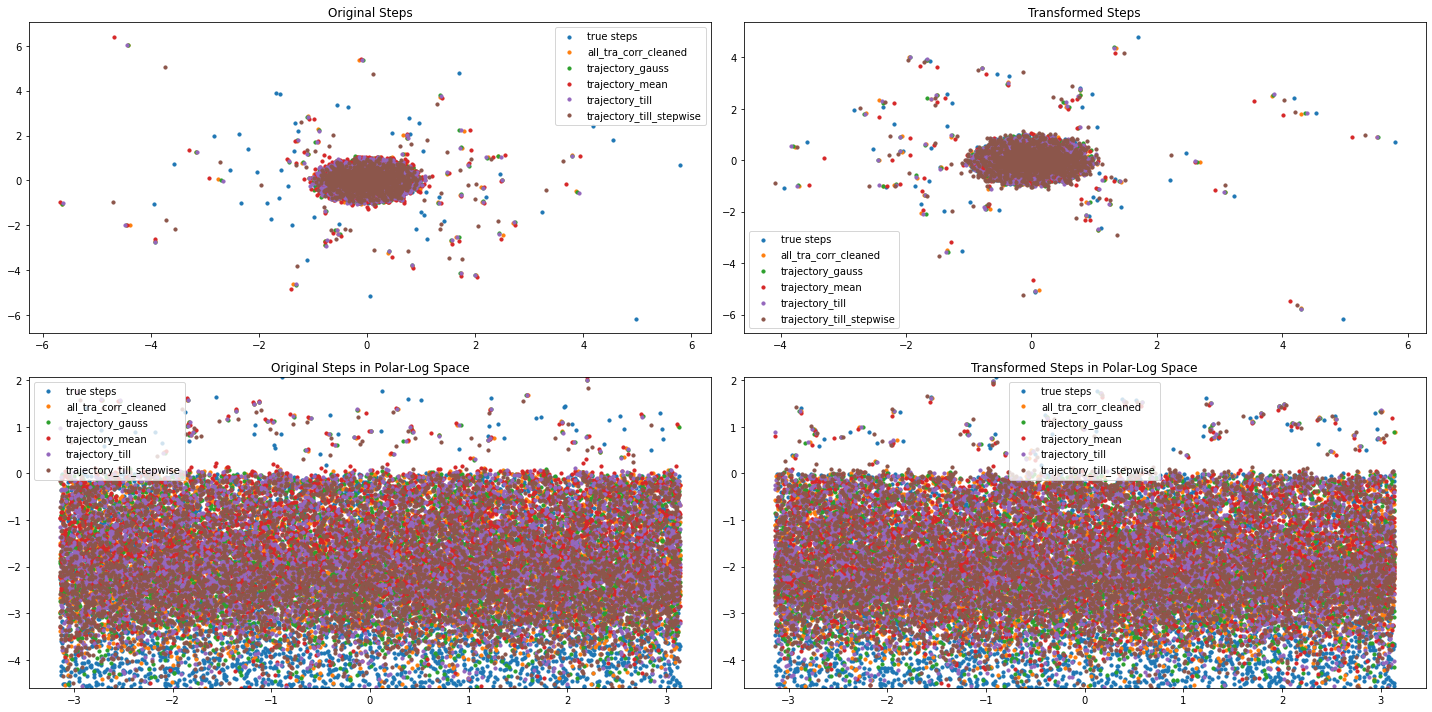

In [116]:
import numpy as np
import matplotlib.pyplot as plt

# Define function to compute transformation matrix
def compute_transformation_matrix(source, target):
    return np.linalg.lstsq(source, target, rcond=None)[0]

# Define function to convert to polar coordinates
def cartesian_to_polar(coords):
    r = np.sqrt(coords[:, 0]**2 + coords[:, 1]**2)
    theta = np.arctan2(coords[:, 1], coords[:, 0])
    return np.column_stack((r, theta))

# Calculate steps
def calculate_steps(data):
    return np.diff(data, axis=0)

# Load your main data
points_0_steps = calculate_steps(all_points)

# Trajectories list
trajectories = [corrected_traj, all_tra_gauss, all_tra_mean, all_tra_till, all_tra_till_stepwise]
labels = ["all_tra_corr_cleaned", "trajectory_gauss", "trajectory_mean", "trajectory_till", "trajectory_till_stepwise"]
transformed_trajectories = []

# Compute transformation matrix for each trajectory and apply it
for tra in trajectories:
    matrix = compute_transformation_matrix(calculate_steps(tra), points_0_steps)
    transformed_trajectories.append(calculate_steps(tra) @ matrix)

# Convert steps to polar coordinates and take the log of the length
transformed_trajectories_polar = [cartesian_to_polar(tra) for tra in transformed_trajectories]
points_polar_steps = cartesian_to_polar(points_0_steps)

# Define ylims for log plots
ylim_min = np.min(np.log(points_polar_steps[:, 0] + 1e-10))
ylim_max = np.max(np.log(points_polar_steps[:, 0] + 1e-10))

# Plotting
plt.figure(figsize=(20, 10))

# Original steps in real space
plt.subplot(2, 2, 1)
plt.scatter(points_0_steps[:, 0], points_0_steps[:, 1], label='true steps', s=10)
for tra, label in zip(trajectories, labels):
    plt.scatter(calculate_steps(tra)[:, 0], calculate_steps(tra)[:, 1], label=label, s=10)
plt.legend()
plt.title('Original Steps')

# Transformed steps in real space
plt.subplot(2, 2, 2)
plt.scatter(points_0_steps[:, 0], points_0_steps[:, 1], label='true steps', s=10)
for tra, label in zip(transformed_trajectories, labels):
    plt.scatter(tra[:, 0], tra[:, 1], label=label, s=10)
plt.legend()
plt.title('Transformed Steps')

# Original steps in polar-log space
plt.subplot(2, 2, 3)
plt.scatter(points_polar_steps[:, 1], np.log(points_polar_steps[:, 0] + 1e-10), label='true steps', s=10)
for tra, label in zip(trajectories, labels):
    tra_polar = cartesian_to_polar(calculate_steps(tra))
    plt.scatter(tra_polar[:, 1], np.log(tra_polar[:, 0] + 1e-10), label=label, s=10)
plt.ylim(ylim_min, ylim_max)
plt.legend()
plt.title('Original Steps in Polar-Log Space')

# Transformed steps in polar-log space
plt.subplot(2, 2, 4)
plt.scatter(points_polar_steps[:, 1], np.log(points_polar_steps[:, 0] + 1e-10), label='true steps', s=10)
for tra, label in zip(transformed_trajectories_polar, labels):
    plt.scatter(tra[:, 1], np.log(tra[:, 0] + 1e-10), label=label, s=10)
plt.ylim(ylim_min, ylim_max)
plt.legend()
plt.title('Transformed Steps in Polar-Log Space')

plt.tight_layout()
plt.show()


In [117]:
results_list=[]
# Loop through each transformed trajectory
for tra, label in zip(transformed_trajectories, labels):
    Stepsize_bins, stepsize_bin_accuracies, sigma_stepsize_bin_accuracies = compare_trajectories(tra, points_0_steps)
    
    results = {
        "Stepsize_bins": Stepsize_bins,
        "stepsize_bin_accuracies": stepsize_bin_accuracies,
        "sigma_stepsize_bin_accuracies": sigma_stepsize_bin_accuracies,
        "test_traj": points_0_steps,
        "calc_traj": tra,
        "name": label
    }
    
    results_list.append(results)

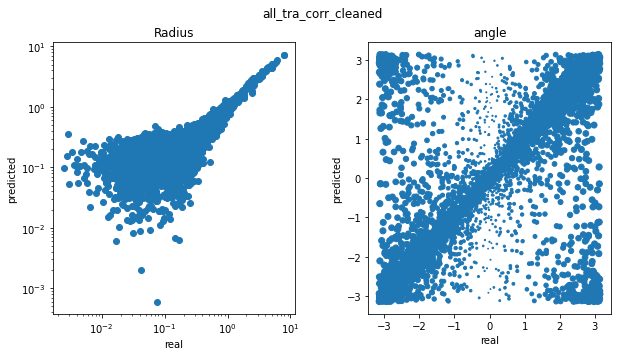

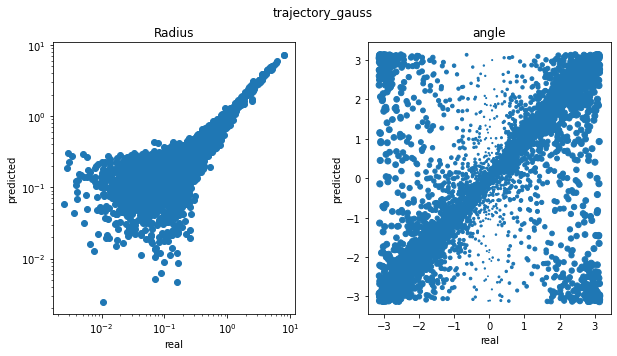

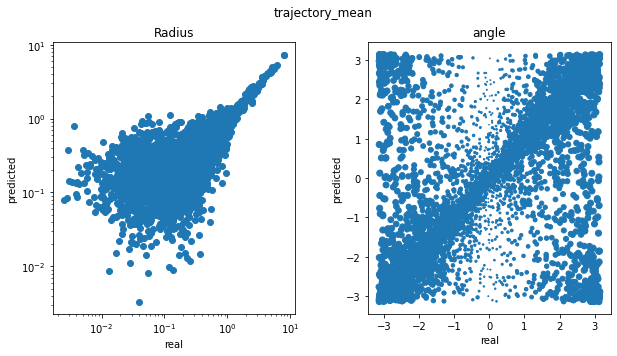

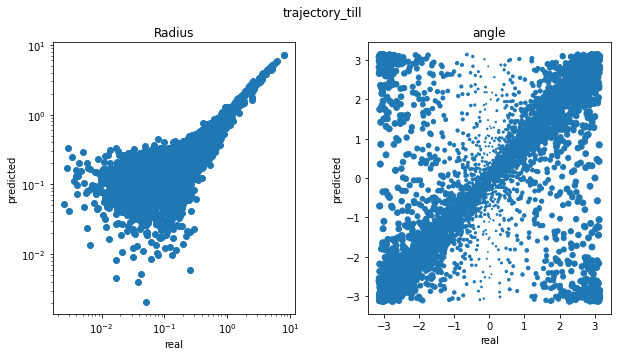

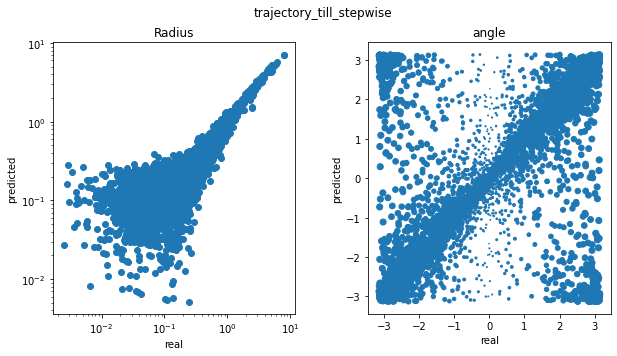

In [118]:
for result in results_list:
    trajectory_polar_comparison(result, result['name'])

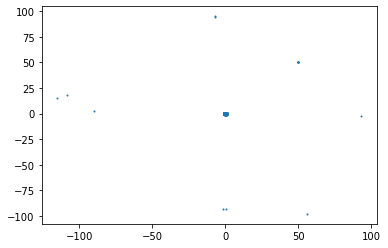

In [24]:
data = np.load(os.path.join(experiment_folder, experiment_name, 'all_tra_corr_steps' + '.npy'))
plt.scatter(data[:, 0], data[:, 1], s=1)

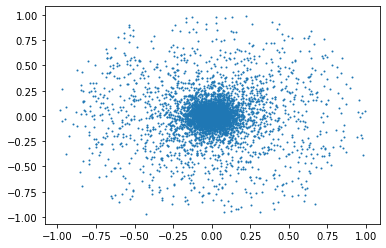

In [25]:
mask = np.any(np.abs(data) > 1, axis=1)
data[mask] = [0, 0]
plt.scatter(data[:, 0], data[:, 1], s=1)

In [21]:
data

array([[-7.18966981e-01,  1.25811796e-01],
       [-1.76536661e-01, -2.92324356e-01],
       [ 1.60930434e-01,  8.57641281e-02],
       ...,
       [-4.32887059e-02,  4.08544251e-02],
       [-3.15048643e-04, -1.62890724e-01],
       [ 4.09586116e-01,  1.86445018e-01]])

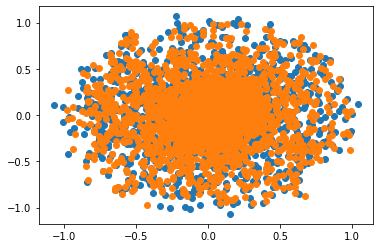

In [8]:
plt.scatter(all_tra_gauss[:,0],all_tra_gauss[:,1])
plt.scatter(all_tra_corr[:,0],all_tra_corr[:,1])


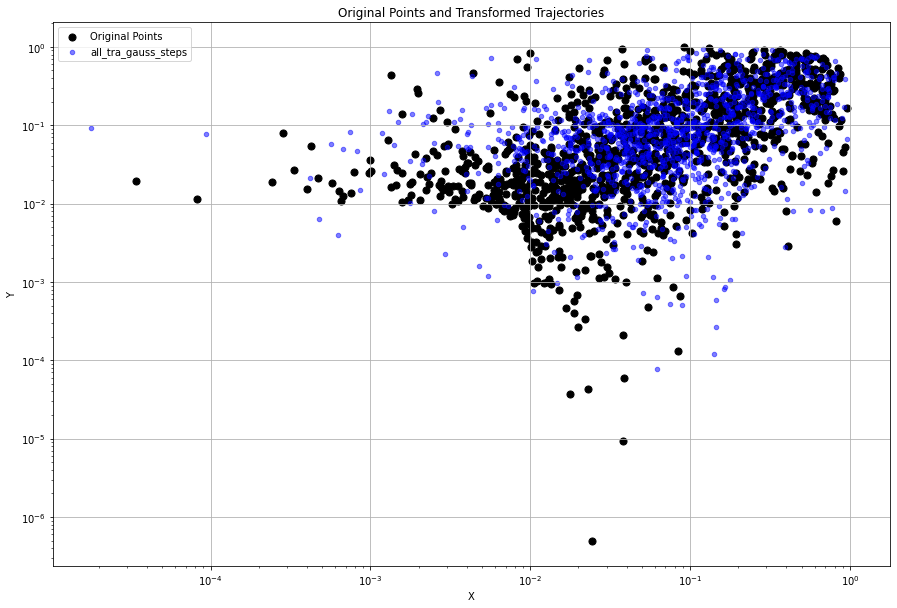

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Define a function to compute the transformation matrix
def compute_transformation_matrix(source, target):
    return np.linalg.lstsq(source, target, rcond=None)[0]

# Load your main data
all_points = np.load(os.path.join(experiment_folder, experiment_name, 'all_steps.npy'))

# Compute transformation matrices for each trajectory
matrices = {}
trajectories = ["all_tra_corr_steps", "all_tra_gauss_steps", "all_tra_mean_steps", "all_tra_till_steps", "all_tra_till_stepwise_steps"]

for tra in trajectories:
    data = np.load(os.path.join(experiment_folder, experiment_name, tra + '.npy'))
    if tra == 'all_tra_corr_steps':
        mask =np.any(np.abs(data) > 1, axis=1)
        data[mask] = [0, 0]
    matrices[tra] = compute_transformation_matrix(data, all_points)

# Plot the results
plt.figure(figsize=(15, 10))

# Plot original points
plt.scatter(all_points[:, 0], all_points[:, 1], s=50, c='black', label='Original Points')

# Plot transformed trajectories
colors = ['red', 'blue', 'green', 'cyan', 'magenta']
for idx, tra in enumerate(trajectories):
    data = np.load(os.path.join(experiment_folder, experiment_name, tra + '.npy'))
    if tra == 'all_tra_corr_steps':
        mask =np.any(np.abs(data) > 1, axis=1)
        data[mask] = [0, 0]
    transformed_data = data @ matrices[tra]
    if tra == 'all_tra_gauss_steps':
        plt.scatter(transformed_data[:, 0], transformed_data[:, 1], s=20, c=colors[idx], alpha=0.5, label=tra)
    #plt.scatter(transformed_data[:, 0], transformed_data[:, 1], s=20, c=colors[idx], alpha=0.5, label=tra)

plt.legend()
plt.title('Original Points and Transformed Trajectories')
plt.xlabel('X')
plt.ylabel('Y')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.show()


In [30]:
matrices

{'all_tra_corr_steps': array([[-0.95271791, -0.00100297],
        [-0.00413329, -0.92660331]]),
 'all_tra_gauss_steps': array([[-0.95534417,  0.0016863 ],
        [-0.00218257, -0.929666  ]]),
 'all_tra_mean_steps': array([[-0.83541827, -0.03183521],
        [-0.01786493, -0.79670145]]),
 'all_tra_till_steps': array([[-0.95763169, -0.00490004],
        [-0.00779441, -0.93661584]]),
 'all_tra_till_stepwise_steps': array([[-1.10534251, -0.0017491 ],
        [-0.00712033, -1.09273986]])}

In [19]:
matrices

{'all_tra_corr': array([[-0.01306867, -0.00236647],
        [ 0.0193162 , -0.02570053]]),
 'all_tra_gauss': array([[-1.00536411,  0.02125168],
        [-0.00305475, -0.96638148]]),
 'all_tra_mean': array([[-0.9799521 ,  0.00447206],
        [ 0.00207508, -0.93327024]]),
 'all_tra_till': array([[-1.00784662,  0.02079047],
        [-0.00307953, -0.9680693 ]]),
 'all_tra_till_stepwise': array([[-1.15465331,  0.03128188],
        [ 0.00130907, -1.11429391]])}

In [17]:
all_tra_corr[101]

array([-0., -0.])

In [50]:
datapoint_folder = os.path.join(experiment_folder, experiment_name, datapoint_name)
movie = np.load(os.path.join(datapoint_folder, 'movie.npy'))

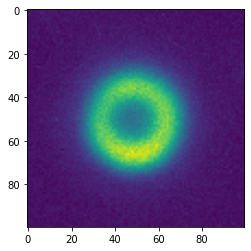

In [56]:
plt.imshow(movie[4])

In [78]:
trajectory_corr(movie[50:78])

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1200.

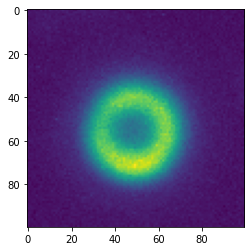

In [75]:
plt.imshow(movie[75])

In [66]:
movie.shape

(101, 100, 100)

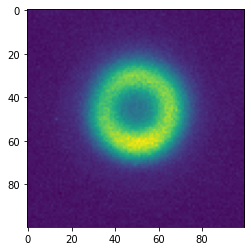

In [44]:
img_1=snap_image()
plt.imshow(img_1)

In [43]:
img_list=[] 
for position in motor_positions:
    move_stage(pidevice, 1, position[0])
    move_stage(pidevice, 2, position[1])
    sleep(0.1)
    img_list.append(snap_image())
    

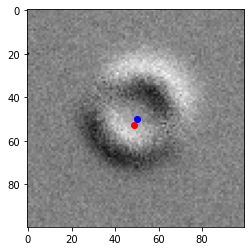

In [44]:
i=56
img=img_list[0]
plt.imshow(img_list[i]-img, cmap='gray')
plt.scatter(img.shape[0]/2,img.shape[1]/2,c='b')
plt.scatter(img.shape[0]/2+points[i][1],img.shape[1]/2+points[i][0],c='r')

In [45]:
movie=np.array(img_list)

In [46]:
tra_corr=trajectory_corr(movie)
tra_gauss=trajectory_gauss(movie)
tra_mean=trajectory_mean(movie)
tra_till=trajectory_till(movie)
tra_till_stepwise=trajectory_till_stepwise(movie)


c:\Users\BetzLab-Admin\Desktop\git-code\mbr_relevant_code\experiments\method_comparison\../../lib\detection_methods.py:192: RuntimeWarning: invalid value encountered in sqrt
  return popt, np.sqrt(np.diag(pcov))


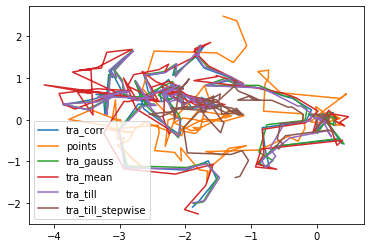

In [59]:
import matplotlib.pyplot as plt

plt.plot(tra_corr[:,0], tra_corr[:,1], label='tra_corr')
plt.plot(-points[:,0], points[:,1], label='points')
plt.plot(tra_gauss[:,0], tra_gauss[:,1], label='tra_gauss')
plt.plot(tra_mean[:,0], tra_mean[:,1], label='tra_mean')
plt.plot(tra_till[:,0], tra_till[:,1], label='tra_till')
plt.plot(tra_till_stepwise[:,0], tra_till_stepwise[:,1], label='tra_till_stepwise')

# Adding the legend
plt.legend(loc='best')  # 'best' will automatically choose the best location for the legend

plt.show()


In [171]:
output=compare_trajectories(tra_corr,points)

([0.17632988918294062,
  0.22531160275435727,
  0.6975705227799652,
  0.8922027876474964,
  0.5682081920125752,
  0.11052745334101653,
  0.1439077777905766,
  0.34345744450612015,
  0.28764591586976224,
  0.4401185540589157,
  0.996383485876619],
 [1.1361636509210782,
  0.553631831921665,
  0.21787161202049193,
  0.1983963269945296,
  0.2430212611388842,
  1.8130039093661796,
  1.0458609075353344,
  0.3309212702357719,
  0.6329028577290114,
  0.33933619336370857,
  0.21388573517414652],
 [1.314701872197068,
  0.2718287973221992,
  0.1207511887125336,
  0.10291901565076522,
  0.1196420147516573,
  1.1059326446186306,
  0.687507318142972,
  0.14834442036563192,
  0.37935842561490096,
  0.12781306480419727,
  0.0])